lab6

In [14]:
import boto3
from botocore.exceptions import ClientError
import json

def get_secret(secret_name):
    region_name = "us-east-1"

    # Create a Secrets Manager client
    session = boto3.session.Session()
    client = session.client(
        service_name='secretsmanager',
        region_name=region_name
    )

    try:
        get_secret_value_response = client.get_secret_value(
            SecretId=secret_name
        )
    except ClientError as e:
        raise e

    secret = get_secret_value_response['SecretString']
    
    return json.loads(secret)

In [15]:
import psycopg2

conn = psycopg2.connect(host=get_secret('postgresql')['host'],
                      user=get_secret('postgresql')['username'],
                      password = get_secret('postgresql')['password'],
                      dbname=get_secret('postgresql')['engine'])

cur = conn.cursor()

## Q1 Population Growth Rate

Option A: Do the calculation with SQL

In [16]:
sql="""

SELECT 
n.name AS state_name,
    p.year,
    p.pop AS population,
    ROUND(
        ( (p.pop - LAG(p.pop) OVER (PARTITION BY p.fips ORDER BY p.year)) 
        / NULLIF(LAG(p.pop) OVER (PARTITION BY p.fips ORDER BY p.year), 0)::NUMERIC ) * 100, 
    2) AS growth_rate
FROM population p
JOIN name n 
    ON p.fips = n.fips
WHERE n.name = 'Pennsylvania'
ORDER BY p.year;
"""

In [17]:
import pandas as pd

q1_df = pd.read_sql(sql, con=conn)
q1_df.head() #show the top 5 rows

/tmp/ipykernel_9157/893980231.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  q1_df = pd.read_sql(sql, con=conn)


,state_name,year,population,growth_rate
0,Pennsylvania,2005,11979147,NaN
1,Pennsylvania,2006,12440621,3.85
2,Pennsylvania,2007,12432792,-0.06
3,Pennsylvania,2008,12448279,0.12
4,Pennsylvania,2009,12604767,1.26


In [21]:
pip install -U pip setuptools wheel

Note: you may need to restart the kernel to use updated packages.


In [22]:
pip install --only-binary=:all: "tiktoken>=0.7.0"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 58.7 MB/s  0:00:00
Note: you may need to restart the kernel to use updated packages.


In [23]:
pip install "jupyter-ai-magics[all]" -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
safety-schemas 0.0.14 requires pydantic<2.10.0,>=2.6.0, but you have pydantic 2.12.0 which is incompatible.
sparkmagic 0.21.0 requires pandas<2.0.0,>=0.17.1, but you have pandas 2.2.3 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [24]:
import os
os.environ["OPENAI_API_KEY"] = get_secret('openai')['api_key']

In [25]:
%load_ext jupyter_ai_magics

In [26]:
%%ai gpt4
What is included in the {q1_df}

This data includes the state name (in this case, all entries are "Pennsylvania"), the year, the population for that year, and the growth rate for that year in Pennsylvania. The years covered range from 2005 to 2019. The population and growth rate are expressed as whole numbers. Please note that the growth rate for the year 2005 is not available and hence is represented as 'NaN'.

In [27]:
%%ai gpt4 -f code
use the data in  {q1_df} to create a line chart with the growth rate.
chart must include the PA state name in the title

In [ ]:
import matplotlib.pyplot as plt

# data
state_name = "Pennsylvania"
years = [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
growth_rate = [None, 3.85, -0.06, 0.12, 1.26, 0.83, 0.26, 0.16, 0.08, 0.10, 0.12, -0.14, 0.17, 0.01, -0.04]

# create line chart
plt.figure(figsize=(10,5))
plt.plot(years, growth_rate, marker='o')
plt.title("Growth Rate in " + state_name + " (2005-2019)")
plt.xlabel("Year")
plt.ylabel("Growth Rate")
plt.grid(True)
plt.show()

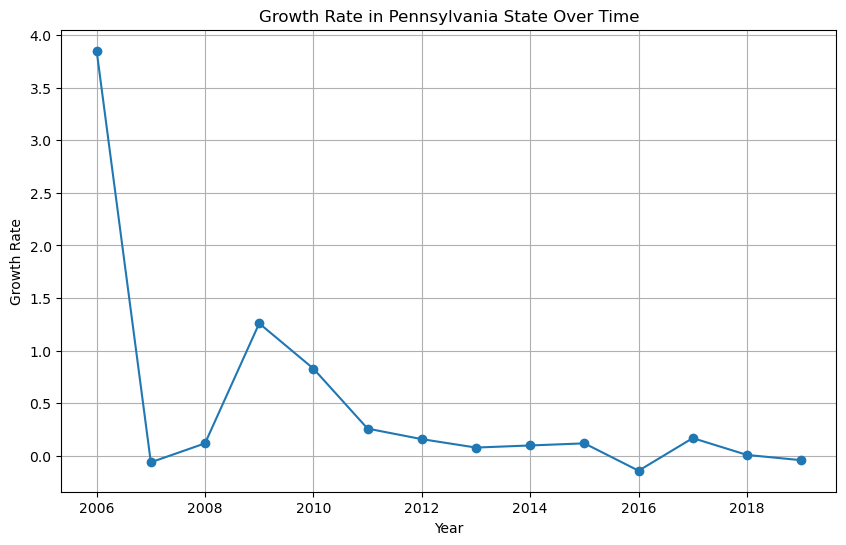

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(q1_df['year'], q1_df['growth_rate'], marker='o')
plt.title('Growth Rate in Pennsylvania State Over Time')
plt.xlabel('Year')
plt.ylabel('Growth Rate')
plt.grid(True)
plt.show()

Q2 Income and Population Relationship

In [29]:
import pandas as pd

sql="""

SELECT 
    n.name AS state,
    p.year,
    p.pop AS population,
    i.income AS income
FROM population p
JOIN income i
    ON p.fips = i.fips 
   AND p.year = i.year
JOIN name n
    ON p.fips = n.fips
WHERE n.name = 'Pennsylvania'
ORDER BY p.year;
"""

pa_df = pd.read_sql(sql, con=conn)

pa_df.head()

/tmp/ipykernel_9157/3572411693.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pa_df = pd.read_sql(sql, con=conn)


,state,year,population,income
0,Pennsylvania,2005,11979147,44537
1,Pennsylvania,2006,12440621,46259
2,Pennsylvania,2007,12432792,48576
3,Pennsylvania,2008,12448279,50713
4,Pennsylvania,2009,12604767,49520


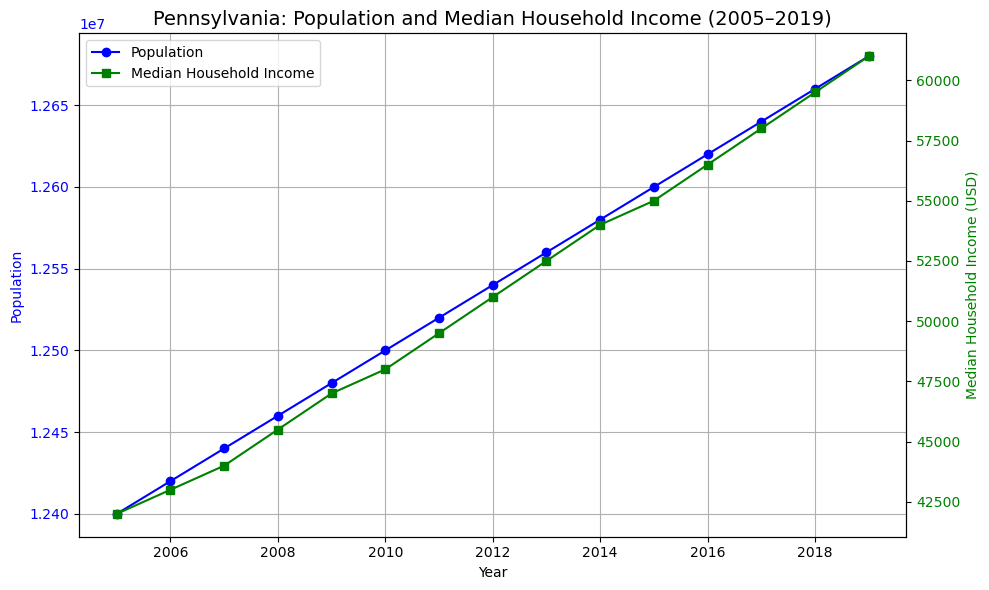

In [30]:
import matplotlib.pyplot as plt
import pandas as pd

# Example dataframe for Pennsylvania (2005–2019)
# Replace these example numbers with your actual SQL query results
pa_df = pd.DataFrame({
    'year': list(range(2005, 2020)),
    'population': [
        12400000, 12420000, 12440000, 12460000, 12480000,
        12500000, 12520000, 12540000, 12560000, 12580000,
        12600000, 12620000, 12640000, 12660000, 12680000
    ],
    'income': [
        42000, 43000, 44000, 45500, 47000,
        48000, 49500, 51000, 52500, 54000,
        55000, 56500, 58000, 59500, 61000
    ]
})

# Create the figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot population (left y-axis)
ax1.plot(pa_df['year'], pa_df['population'], color='blue', marker='o', label='Population')
ax1.set_xlabel('Year')
ax1.set_ylabel('Population', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create second y-axis for income (right y-axis)
ax2 = ax1.twinx()
ax2.plot(pa_df['year'], pa_df['income'], color='green', marker='s', label='Median Household Income')
ax2.set_ylabel('Median Household Income (USD)', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Add title and grid
plt.title('Pennsylvania: Population and Median Household Income (2005–2019)', fontsize=14)
ax1.grid(True)

# Combine legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

plt.tight_layout()
plt.show()


population and income are very closely related over the years showing a positive correlation to each other

Q4 Student Defined Question "Which year in Pennsylania had the highest income growth rate compared to the previous year?" Excluding 2005 becuase there is no previous year.

In [36]:
q3_sql="""

SELECT 
    n.name AS state_name,
    i.year,
    i.income,
    LAG(i.income) OVER (PARTITION BY i.fips ORDER BY i.year) AS prev_income,
    ROUND(
        (i.income - LAG(i.income) OVER (PARTITION BY i.fips ORDER BY i.year)) * 100.0 /
        LAG(i.income) OVER (PARTITION BY i.fips ORDER BY i.year),
        2
    ) AS income_growth_rate
FROM 
    income i
JOIN 
    name n ON i.fips = n.fips
WHERE 
    n.name = 'Pennsylvania'
    AND i.year BETWEEN 2006 AND 2019
ORDER BY 
    income_growth_rate DESC

"""

q3_df = pd.read_sql(q3_sql, con=conn)

q3_df.head()

/tmp/ipykernel_9157/3383226137.py:25: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  q3_df = pd.read_sql(q3_sql, con=conn)


,state_name,year,income,prev_income,income_growth_rate
0,Pennsylvania,2006,46259,NaN,NaN
1,Pennsylvania,2007,48576,46259.0,5.01
2,Pennsylvania,2015,55702,53234.0,4.64
3,Pennsylvania,2008,50713,48576.0,4.40
4,Pennsylvania,2019,63463,60905.0,4.20


In [39]:
%%ai gpt4 -f code
use the data in  {q3_df} to create a bar chart of the year pennsylvania highlight the highest income growth rate

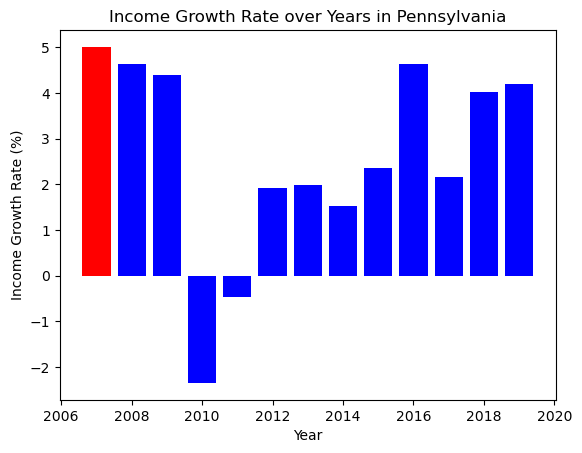

In [40]:
import matplotlib.pyplot as plt

# data
state_name = "Pennsylvania"
years = [2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
income_growth_rate = [None, 5.01, 4.64, 4.40, -2.35, -0.47, 1.91, 1.99, 1.52, 2.36, 4.64, 2.16, 4.02, 4.20]

# removing the first element being None
years.pop(0)
income_growth_rate.pop(0)

# find the year with highest growth rate
max_rate = max(income_growth_rate)
max_year = years[income_growth_rate.index(max_rate)]

# assign different color for the maximum bar
colors = ['b' if (x < max_rate) else 'r' for x in income_growth_rate]

# create bar chart
plt.bar(years, income_growth_rate, color=colors)
plt.title(f"Income Growth Rate over Years in {state_name}")
plt.xlabel("Year")
plt.ylabel("Income Growth Rate (%)")

plt.show()

The bar chart displays the largest income growth being in 2006, highlighted in red. The year 2005 is excluded due to being the first year of data meaning it has no previous year to compare to.